In [1]:
pip install tensorflow.keras

In [2]:

# Cell 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime
import random


In [3]:

# Cell 2: Generate synthetic dataset for city pollution and weather
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=500, freq="D")
pm25 = np.random.normal(loc=60, scale=15, size=(500,))
temperature = np.random.normal(loc=25, scale=5, size=(500,))
humidity = np.random.normal(loc=50, scale=10, size=(500,))
risk = np.where(pm25 > 80, 1, 0)

data = pd.DataFrame({"date": dates, "pm25": pm25, "temperature": temperature, "humidity": humidity, "risk": risk})
data.head()


,date,pm25,temperature,humidity,risk
0,2020-01-01,67.450712,29.630888,63.993554,0
1,2020-01-02,57.926035,34.547083,59.246337,0
2,2020-01-03,69.715328,18.007162,50.596304,0
3,2020-01-04,82.845448,27.814846,43.530632,1
4,2020-01-05,56.487699,21.746787,56.982233,0


In [4]:

# Cell 3: Exploratory Data Analysis
print(data.describe())


                      date        pm25  temperature    humidity        risk
count                  500  500.000000   500.000000  500.000000  500.000000
mean   2020-09-06 12:00:00   60.102570    25.159131   51.084845    0.096000
min    2020-01-01 00:00:00   11.380990    11.515567   21.037446    0.000000
25%    2020-05-04 18:00:00   49.495389    22.023541   43.975704    0.000000
50%    2020-09-06 12:00:00   60.191957    25.142658   51.198058    0.000000
75%    2021-01-09 06:00:00   69.551749    28.256211   57.547384    0.000000
max    2021-05-14 00:00:00  117.790972    38.161910   76.016831    1.000000
std                    NaN   14.718799     4.889986   10.102463    0.294886


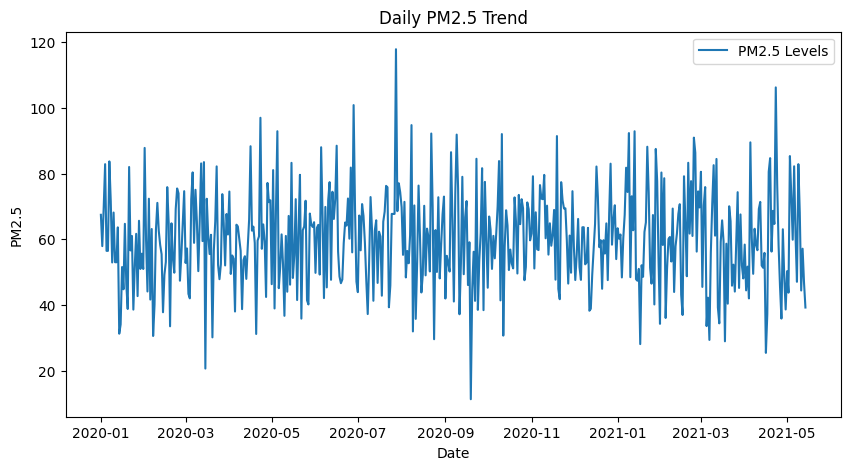

In [5]:

# Cell 4: Plot PM2.5 levels
plt.figure(figsize=(10,5))
plt.plot(data['date'], data['pm25'], label="PM2.5 Levels")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Daily PM2.5 Trend")
plt.legend()
plt.show()


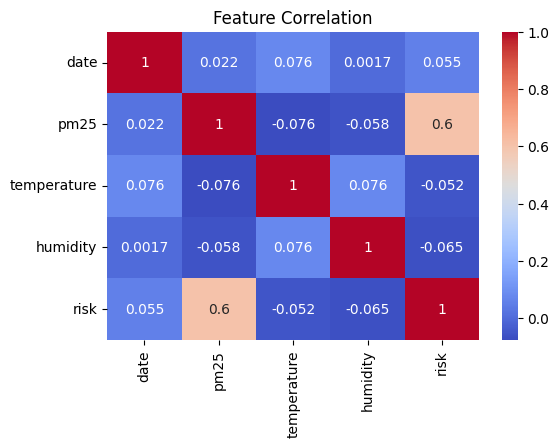

In [6]:

# Cell 5: Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


In [7]:

# Cell 6: Train-test split
X = data[["pm25", "temperature", "humidity"]]
y = data["risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:

# Cell 7: Train RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00         8

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



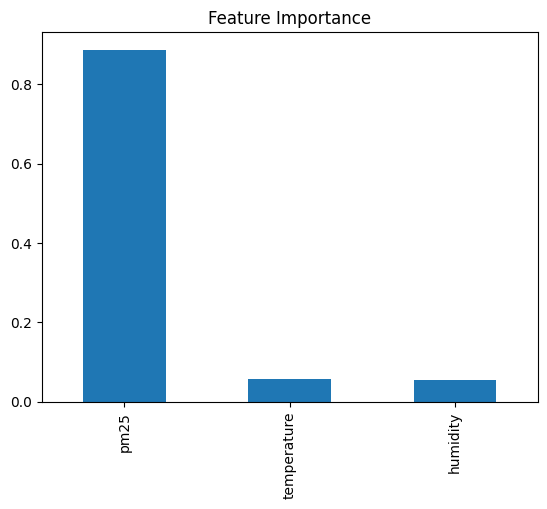

In [9]:

# Cell 8: Feature importance plot
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.plot(kind="bar", title="Feature Importance")
plt.show()


In [10]:

# Cell 9: Prepare data for LSTM (time series forecasting PM2.5)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pm25_scaled = scaler.fit_transform(data['pm25'].values.reshape(-1,1))

X_lstm, y_lstm = [], []
for i in range(30, len(pm25_scaled)):
    X_lstm.append(pm25_scaled[i-30:i, 0])
    y_lstm.append(pm25_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


In [11]:

# Cell 10: Build and train LSTM model
model = keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    layers.LSTM(50),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
history = model.fit(X_lstm, y_lstm, epochs=5, batch_size=32, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.1192
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0243
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0206
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0171
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0197


In [12]:
# Cell 11: Forecast PM2.5 for next 10 days

last_30 = pm25_scaled[-30:]
last_30 = np.reshape(last_30, (1, 30, 1))

predictions = []

for _ in range(10):
    pred = model.predict(last_30, verbose=0)
    predictions.append(pred[0,0])

    last_30 = np.append(last_30[:,1:,:], np.array([[[pred[0,0]]]]), axis=1)


pred_pm25 = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

print("Next 10 days PM2.5 forecast:", pred_pm25.flatten())


Next 10 days PM2.5 forecast: [62.8664   62.344646 62.000904 61.79511  61.686195 61.673473 61.748123
 61.861225 62.007504 62.14921 ]


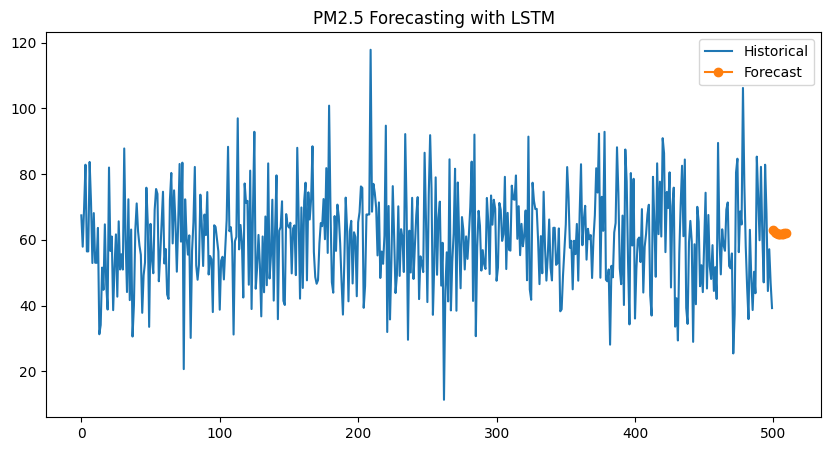

In [13]:

# Cell 12: Plot actual vs forecasted PM2.5
plt.figure(figsize=(10,5))
plt.plot(range(len(data['pm25'])), data['pm25'], label="Historical")
plt.plot(range(len(data['pm25']), len(data['pm25'])+10), pred_pm25, label="Forecast", marker="o")
plt.legend()
plt.title("PM2.5 Forecasting with LSTM")
plt.show()


In [14]:

# Cell 13: Simulate live data stream (random values)
live_data = {
    "date": datetime.datetime.now(),
    "pm25": random.randint(40,120),
    "temperature": random.randint(20,35),
    "humidity": random.randint(30,70)
}
print("Live data received:", live_data)


Live data received: {'date': datetime.datetime(2025, 8, 29, 5, 59, 51, 159540), 'pm25': 116, 'temperature': 28, 'humidity': 45}


In [15]:
# ✅ Step 1: Install dependencies
!pip install streamlit pyngrok -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.1 MB/s eta 0:00:00


In [16]:
# ✅ Step 2: Write your Streamlit app
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

st.set_page_config(page_title="Future City Digital Twin", page_icon="🌆")

st.title("🌆 Future City Digital Twin Dashboard")

# ---- Past Data (from CSV) ----
try:
    df = pd.read_csv("/content/drive/MyDrive/delhi_aqi - delhi_aqi.csv", parse_dates=['date'])
    last_30 = df.tail(30)

    st.subheader("📊 Past 30 Days PM2.5 Trend")
    fig, ax = plt.subplots()
    ax.plot(last_30['date'], last_30['pm25'], marker='o')
    ax.set_xlabel("Date")
    ax.set_ylabel("PM2.5")
    st.pyplot(fig)

except Exception as e:
    st.error(f"Could not fetch past data: {e}")

# ---- Live Data Simulation ----
st.subheader("📡 Live Data Simulation")
live_data = {
    "date": datetime.datetime.now(),
    "pm25": random.randint(40,120),
    "temperature": random.randint(20,35),
    "humidity": random.randint(30,70)
}
st.write(live_data)

# ---- Forecast (example static values, can replace with LSTM output) ----
st.subheader("🔮 PM2.5 Forecast Next 10 Days")
forecast = np.linspace(55, 65, 10) + np.random.randn(10)
st.line_chart(forecast)

st.success("✅ Dashboard is running successfully!")


Writing app.py


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ---- Installations ----
!pip install streamlit pyngrok -q

# ---- Save Streamlit App Code to app.py ----
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Load Dataset ----
df = pd.read_csv("/content/drive/MyDrive/delhi_aqi.csv")   # apna dataset ka path

# Normalize columns
df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

# Rename pm2.5 -> pm25 if exists
if "pm2.5" in df.columns:
    df.rename(columns={"pm2.5": "pm25"}, inplace=True)

# Rename pm2_5 -> pm25 if exists (for your case)
if "pm2_5" in df.columns:
    df.rename(columns={"pm2_5": "pm25"}, inplace=True)

# Debug info
st.write("✅ Columns Loaded:", df.columns.tolist())
st.write("📊 Dataset shape:", df.shape)

# Convert date column
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Ensure numeric
pollutants = ['co','no','no2','o3','so2','pm25','pm10','nh3']
for col in pollutants:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

def main():
    st.title("🌦️ Weather & Pollution Dashboard with Predictions")

    # ---- Past Data ----
    if "pm25" in df.columns:
        # Check if we have valid PM2.5 data
        pm25_data = df["pm25"].dropna()

        if len(pm25_data) == 0:
            st.error("❌ PM2.5 column exists but contains no valid data (all values are NaN)")
            return

        st.subheader("📊 Past PM2.5 Levels")
        fig, ax = plt.subplots()
        ax.plot(df["date"], df["pm25"], label="Past PM2.5", color="blue")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 (µg/m³)")
        ax.legend()
        st.pyplot(fig)

        # ---- Dummy Prediction ----
        last_val = pm25_data.iloc[-1]  # Use the cleaned data
        y_pred = last_val + np.random.randn(30)

        # ---- Next 7 Days ----
        future_dates = pd.date_range(start=df["date"].dropna().iloc[-1], periods=8, freq="D")[1:]
        y_pred_7 = y_pred[:7]
        future_df = pd.DataFrame({"date": future_dates, "pm25": y_pred_7})

        st.subheader("🔮 Predicted PM2.5 Levels (Next 7 Days)")
        st.dataframe(future_df)

        fig2, ax2 = plt.subplots()
        ax2.plot(df["date"], df["pm25"], label="Past PM2.5", color="blue")
        ax2.plot(future_df["date"], future_df["pm25"], label="Predicted PM2.5", color="red", linestyle="--")
        ax2.set_xlabel("Date")
        ax2.set_ylabel("PM2.5 (µg/m³)")
        ax2.legend()
        st.pyplot(fig2)
    else:
        st.error("❌ Dataset me 'pm25' column nahi mila. Please check your CSV file.")
        st.write("Available columns:", df.columns.tolist())

if __name__ == "__main__":
    main()
"""

# Write file
with open("app.py", "w") as f:
    f.write(app_code)

# ---- Ngrok Setup ----
from pyngrok import ngrok

# Apna authtoken lagao (sirf ek baar run karna hota hai per session)
!ngrok config add-authtoken 31SyS6uCIrA3rqMYUcfoXmEbwp1_7gfRor5GqKvtWPu2yhvyq

# Start tunnel
public_url = ngrok.connect(8501)
print("🌍 Streamlit App URL:", public_url)

# ---- Run Streamlit ----
!streamlit run app.py --server.port 8501 --server.fileWatcherType none

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌍 Streamlit App URL: NgrokTunnel: "https://6c1d4005d9bb.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.103.220:8501



In [ ]:
print(df.columns)


Index(['date', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'], dtype='object')
